# Imports

In [1]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")
warnings.filterwarnings("ignore", category=FutureWarning, message="is_sparse is deprecated")



# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

In [4]:
print(len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

136245
Int64Index([118664], dtype='int64')
136244


[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<AxesSubplot:title={'center':'Target C Clean'}, xlabel='time'>

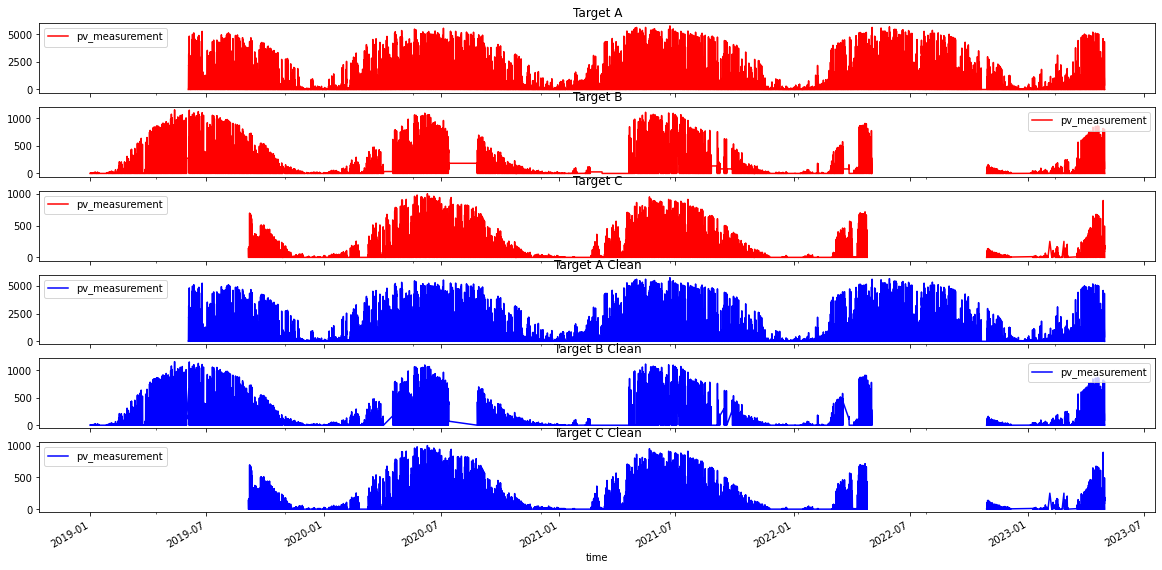

In [5]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data clean up an aggregation

In [6]:
# Making sure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median)
   mean = data_agg.gen_agg(mean, "mean")

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


# Feature engineering

In [7]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DTF
import data_func.combine_columns as CC

columns_to_drop = ['snow_density:kgm3', 'elevation:m', 'snow_drift:idx', 'date_forecast']

for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DTF.date_forecast_columns(X_train[i])
    X_train[i] = CC.combine_columns_multiplication(X_train[i], 'clear_sky_total', ['clear_sky_energy_1h:J', 'clear_sky_rad:W'])


for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DTF.date_forecast_columns(X_frames_test[i])
    X_frames_test[i] = CC.combine_columns_multiplication(X_frames_test[i], 'clear_sky_total', ['clear_sky_energy_1h:J', 'clear_sky_rad:W'])


# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = train.append(test, ignore_index = True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=columns_to_drop, inplace=True)
     X_frames_test[i].drop(columns=columns_to_drop, inplace=True)


<ipython-input-7-ccaec7745a87>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)
<ipython-input-7-ccaec7745a87>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)
<ipython-input-7-ccaec7745a87>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)


In [8]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6126,3609,4342
cloud_base_agl:m,2362,1367,1686


In [9]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [10]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

# Training the model

In [11]:

# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)

# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'n_estimators': 980, 'max_depth': 9, 'learning_rate': 0.029035565559484028, 'subsample': 0.8393121619033767, 'colsample_bytree': 0.7589542758688459}
params_b = {'random_state': 42, 'n_estimators': 955, 'max_depth': 9, 'learning_rate': 0.02949625834198986, 'subsample': 0.8030196155828968, 'colsample_bytree': 0.72518389089994}
params_c = {'random_state': 42, 'n_estimators': 727, 'max_depth': 8, 'learning_rate': 0.08609213174337473, 'subsample': 0.8107057409889747, 'colsample_bytree': 0.8763563332327975}
model_a = xgb.XGBRegressor(**params_a)
model_b = xgb.XGBRegressor(**params_b)
model_c = xgb.XGBRegressor(**params_c)


model_a.fit(x_train_a, y_train_a)
model_b.fit(x_train_b, y_train_b)
model_c.fit(x_train_c, y_train_c)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8763563332327975, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08609213174337473, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=727, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Evaluate prediction

In [12]:
# Evaluate the model based on the validation data

mae_a = mean_absolute_error(y_val_a, model_a.predict(x_val_a))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_val_b, model_b.predict(x_val_b))
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_val_c, model_c.predict(x_val_c))
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

# Get feature importance scores
models = [(model_a, 'A'), (model_b, 'B'), (model_c, 'C')]
for model in models:

    feature_importance_scores = model[0].feature_importances_

# Create a DataFrame to associate features with their importance scores
    feature_importance_df1 = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance_scores})

# Sort features by importance in descending order
    feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance scores
    pd.set_option('display.max_rows', 500)
    feature_importance_df1.head(500)
    print(f'Model {model[1]}')
    print(feature_importance_df1)
    pd.reset_option('display.max_rows')


MAE for A:  154.90548853498993
MAE for B:  22.65604183463657
MAE for C:  18.903867865194243
Mean MAE:  65.48846607827358
Score A:  0.9065132616331424
Score B:  0.9291320689033675
Score C:  0.919262299833434

Model A
                           Feature  Importance
11                    direct_rad:W    0.387099
12                 direct_rad_1h:J    0.130106
9                    diffuse_rad:W    0.049022
6                  clear_sky_rad:W    0.035808
47                           hours    0.026553
31                 sun_elevation:d    0.026325
52          precip_type_5min:idx_0    0.024818
20                  precip_5min:mm    0.021616
16               fresh_snow_24h:cm    0.021070
48                 clear_sky_total    0.018939
40                       sinus_day    0.017635
30                   sun_azimuth:d    0.016826
45                           month    0.014607
43                    cosinus_year    0.012271
13         effective_cloud_cover:p    0.010204
44                            ye

```
Most_common = ['direct_rad:W', 'clear_sky_rad:W']

MSE for A:  155326.11984010294
MSE for B:  4311.822664627681
MSE for C:  2484.332046556924
Mean MSE:  54040.75818376252
Score A:  0.8869367102250868
Score B:  0.8880678863853381
Score C:  0.9167532450100108

Model A
                 Feature  Importance
9           direct_rad:W    0.558548 <-------- 3
7          diffuse_rad:W    0.077622 <-------- 2
18      is_in_shadow:idx    0.028293 <--------2
3        clear_sky_rad:W    0.026308 <-------- 3
40          cosinus_year    0.024731
24     snow_density:kgm3    0.022149 <-------- 2
29         sun_azimuth:d    0.021677
20  precip_type_5min:idx    0.016280
6         dew_point_2m:K    0.015750
19        precip_5min:mm    0.014176 <-------- 2

Model B
             Feature  Importance
9       direct_rad:W    0.369634     <--------- 3
30   sun_elevation:d    0.165624     <-------- 2
3    clear_sky_rad:W    0.084479     <--------- 3
18  is_in_shadow:idx    0.074470     <---------
17        is_day:idx    0.037519
22   rain_water:kgm2    0.028054
40      cosinus_year    0.024928
7      diffuse_rad:W    0.019828     <--------- 2
39        sinus_year    0.016917
16  fresh_snow_6h:cm    0.015372     <-------- 1/2

Model C
                 Feature  Importance
30       sun_elevation:d    0.737467 <--------- 2
3        clear_sky_rad:W    0.110762 <--------- 3
9           direct_rad:W    0.029844 <--------- 3
10       direct_rad_1h:J    0.023283
20  precip_type_5min:idx    0.010948
12     fresh_snow_12h:cm    0.010607
24     snow_density:kgm3    0.009615 <-------- 2
14     fresh_snow_24h:cm    0.007877 <-------- 1/2
6         dew_point_2m:K    0.005590
19        precip_5min:mm    0.005087 <-------- 2
```

# Make predictions

In [13]:
# Train the model on the entire training data
model_a.fit(X_train[0], Y_train[0])
model_b.fit(X_train[1], Y_train[1])
model_c.fit(X_train[2], Y_train[2])

y_pred_a = model_a.predict(X_frames_test[0])
y_pred_b = model_b.predict(X_frames_test[1])
y_pred_c = model_c.predict(X_frames_test[2])
print(len(y_pred_a))

y_pred = np.concatenate((y_pred_a, y_pred_b, y_pred_c), axis=0)



720


In [14]:
print(len(y_pred_a), len(X_frames_test[0]))
print(len(y_pred_b), len(X_frames_test[1]))
print(len(y_pred_c), len(X_frames_test[2]))


720 720
720 720
720 720


In [15]:
for i in range(len(y_pred)):
    if y_pred[i] < 0: 
        y_pred[i] = 0



# Create submission

In [16]:
y_test_pred = y_pred
print(len(y_test_pred))

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_xg.csv', index=False)


2160
